In [5]:
import numpy as np
import numpy as np
from scipy.io import arff
from matplotlib import pyplot as plt

In [6]:
def get_distance(x1, x2):
    """Get Euclidean distane"""
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [32]:
def kmeans(train_x, num_of_clusters, max_iters):
  
    centroids = train_x[np.random.choice(range(len(train_x)), num_of_clusters, replace=False)]
    converged = False
    current_iter = 0

    while (not converged) and (current_iter < max_iters):

        cluster_list = [[] for i in range(len(centroids))]

        for x in train_x:  # Go through each data point
            distances_list = []
            for c in centroids:
                distances_list.append(get_distance(c, x))
            cluster_list[int(np.argmin(distances_list))].append(x)

        cluster_list = list((filter(None, cluster_list)))

        prev_centroids = centroids.copy()

        centroids = []

        for j in range(len(cluster_list)):
            centroids.append(np.mean(cluster_list[j], axis=0))

        pattern = np.abs(np.sum(prev_centroids) - np.sum(centroids))

        converged = (pattern == 0)

        current_iter += 1

    return np.array(centroids), [np.std(x) for x in cluster_list], cluster_list


In [44]:
class RBF:

    def __init__(self, train_x, train_y, test_x, test_y, num_of_classes,
                 num_of_clusters, std_from_clusters=True):
        self.train_x = train_x
        self.train_y = train_y

        self.test_x = test_x
        self.test_y = test_y

        self.number_of_classes = num_of_classes
        self.number_of_clusters = num_of_clusters
        self.std_from_clusters = std_from_clusters

    def rbf(self, x, c, s):
        distance = get_distance(x, c)
        return np.exp(-(distance/ s) ** 2)

    def rbf_list(self, train_x, centroids, std_list):
        RBF_list = []
        for x in train_x:
            RBF_list.append([self.rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(RBF_list)

    def convert_to_one_hot(self, x, num_of_classes):
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    def fit(self):

        self.centroids, self.std_list, _ = kmeans(self.train_x, self.number_of_clusters, max_iters=1000)

        if not self.std_from_clusters:
            dMax = np.max([get_distance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
            self.std_list = np.repeat(dMax / np.sqrt(2 * self.number_of_clusters), self.number_of_clusters)

        RBF_X = self.rbf_list(self.train_x, self.centroids, self.std_list)

        # lms algorithm   
        num_samples, num_features = RBF_X.shape
        self.w = np.random.randn(num_features)

        for iteration in range(100):
            y = np.dot(RBF_X, self.w)
            e = self.train_y - y 
            self.w += 0.001 * (np.dot(e, RBF_X) )
            mse = np.mean(e**2)  

        # self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.train_y, self.number_of_classes)

        RBF_list_tst = self.rbf_list(self.test_x, self.centroids, self.std_list)

        self.pred_ty = RBF_list_tst @ self.w

        self.pred_ty = np.array([np.argmax(x) for x in self.pred_ty])

        diff = self.pred_ty - self.test_y

        print('Accuracy: ', len(np.where(diff == 0)[0]) / len(diff))


In [35]:
data, meta = arff.loadarff("./eeg+eye+state/EEG Eye State.arff")
data = np.array(data.tolist())

# Split data into train and test data set in 80:20 ratio
data = data.astype(np.float32)

train_x = data[0:12000, 0:14]
train_y = data[0:12000, 14]

test_x = data[12000:14980, 0:14]
test_y = data[12000:14980, 14]


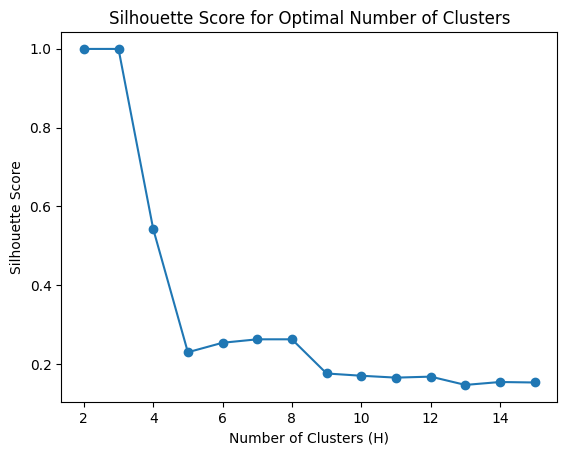

In [11]:
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt


max_clusters = 15
max_iters = 100
silhouette_scores = []

for h in range(2, max_clusters + 1):
    centroids, stds, cluster_list = kmeans(data, h, max_iters)
    labels = np.concatenate([i * np.ones(len(cluster_list[i])) for i in range(len(cluster_list))])
    
    flat_clusters = np.concatenate(cluster_list)

    silhouette_avg = silhouette_score(flat_clusters, labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (H)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

In [45]:
RBF_CLASSIFIER = RBF(train_x, train_y, test_x, test_y, num_of_classes=2,
                     num_of_clusters=14, std_from_clusters=False)

RBF_CLASSIFIER.fit()

C:\Users\Dagmawi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Dagmawi\AppData\Local\Temp\ipykernel_10356\261984141.py:50: RuntimeWarning: overflow encountered in square
  mse = np.mean(e**2)


Accuracy:  0.9114093959731544


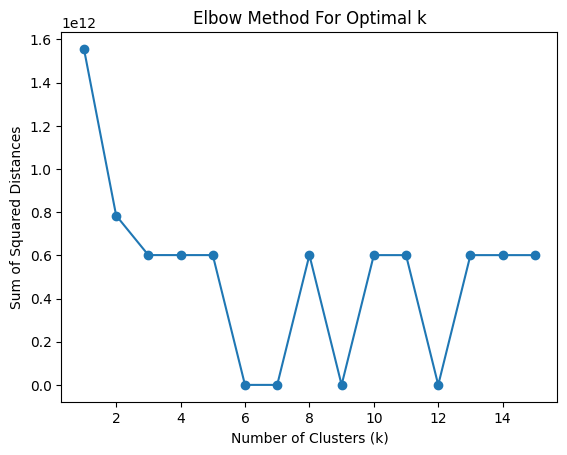

In [12]:
distortions = []
max_clusters = 15

for k in range(1, max_clusters + 1):
    centroids, std, cluster_list = kmeans(data, k, max_iters=100)

    inertia = sum(np.sum((x - centroids[i]) ** 2) for i, cluster in enumerate(cluster_list) for x in cluster)
    distortions.append(inertia)

plt.plot(range(1, max_clusters + 1), distortions, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.show()